<div style="text-align:center; font-family:Arial, sans-serif;">
  <h2>Natural Language Processing – Assignment 1</h2>
  <p><strong>Term:</strong> 4012</p>
  <p><strong>Institution:</strong> Sharif University of Technology</p>
  
</div>
<hr>


https://tahamajlesi.notion.site/CA1-1d09381f908c80e6ad61cc5588ed0f43?pvs=4

<span>
    In this assignment, we work with user comments collected from several well-known poems published on the Ganjoor website. The dataset consists of real-world textual data in Persian. A series of Natural Language Processing (NLP) steps are applied to these comments, including text cleaning, tokenization, normalization, stopword removal, and possibly further analysis such as frequency distribution, sentiment analysis, or topic modeling.
</span>


<h2>Text Exploration and Comment Extraction from the Website</h2>
<div>
    <p>
        In this exercise, the <strong>Scrapy</strong> framework has been used for web crawling.
        Scrapy is a powerful Python library designed for extracting structured data from websites, including text, images, and specific page elements.
    </p>
    <p>
        The following Python script extracts user comments related to selected poems by <strong>Omar Khayyam</strong>, <strong>Hafez</strong>, and <strong>Parvin E'tesami</strong> from the Ganjoor website.
        The extracted comments exhibit a nested structure, meaning that each poem contains comments, and those comments may have reply threads (sub-comments). These are stored in a hierarchical or nested object format for further processing.
    </p>
</div>


<h4>
    Installing Required Packages
</h4>
<div>
    The Scrapy tool is used for text extraction. The `crochet` package is also installed to enable background crawling execution within the Jupyter environment. Using this library, Scrapy extracts data for a specified amount of time, and if the extraction operation has not completed by then, it terminates via a timeout. This tool was chosen to run the code in the interactive Jupyter environment.
</div>


In [2]:
try:
    import scrapy 
except: 
    !pip3 install scrapy
try:
    import crochet
except:
    !pip3 install crochet
try:
    import jsonlines
except:
    !pip3 install jsonlines

<h4>
    Importing Dependencies
</h4>


In [3]:
import scrapy
from scrapy.crawler import CrawlerRunner
import re
from crochet import setup, wait_for, TimeoutError
import jsonlines

setup()


<h4>
    Generating Page URLs for Selected Poets on the Ganjoor Website  
</h4>
<div>
    In this exercise, user comments on the poems of six renowned Persian poets have been extracted from the Ganjoor website. The process involves generating the appropriate page URLs for each poet in order to access and collect their associated comment sections.
</div>


In [ ]:
MAJOR_POETS = {
    'khayyam': {
        'ganjoor_name': 'khayyam',
    },
    'hafez': {
        'ganjoor_name': 'hafez',
    },
    'moulavi': {
        'ganjoor_name': 'moulavi',
    },
    'ferdousi': {
        'ganjoor_name': 'ferdousi',
    },
    'nezami': {
        'ganjoor_name': 'nezami',
    },
    'saadi': {
        'ganjoor_name': 'saadi'
    }
}

GANJOOR_URL = 'https://ganjoor.net/'

def gen_start_urls():
    for poet in MAJOR_POETS.values():
        yield GANJOOR_URL + poet['ganjoor_name'] + '/'

list(gen_start_urls())

['https://ganjoor.net/khayyam/',
 'https://ganjoor.net/hafez/',
 'https://ganjoor.net/moulavi/',
 'https://ganjoor.net/ferdousi/',
 'https://ganjoor.net/nezami/',
 'https://ganjoor.net/saadi/']

<div>
    To limit the dataset size and the number of requests, the comments related to the first 100 poems of each poet are extracted.  
</div>

In [5]:
LIMIT_POEM_PAGE_PER_POET = 300

global poems_crawled_per_poet
poems_crawled_per_poet = {}
for poet in MAJOR_POETS:
    poems_crawled_per_poet[poet] = 0


The variable LIMIT_POEM_PAGE_PER_POET sets an upper limit (in this case, 300) on how many poem pages should be crawled for each poet. The dictionary poems_crawled_per_poet is used to keep track of how many poem pages have been processed for each poet during the crawling process. Initially, all values are set to 0, ensuring that the crawler can incrementally update the count as it navigates through each poet's poems while respecting the defined limit.

<h4>
    Spider Class for Crawling the Ganjoor Website
</h4>
<div>
    The extraction of comments from the Ganjoor website has been implemented using a custom Scrapy spider class. In the Scrapy framework, spiders are specialized classes designed to automate the crawling and data extraction process for specific tasks.
    <br/><br/>
    The crawling begins at the main pages of selected poets and follows links up to a depth of three levels. During this traversal, the spider identifies and filters links that match the URL pattern of individual poem pages. If such a URL is detected, it is passed to the `parse` method for further processing.
    <br/><br/>
    When a URL is confirmed to be a poem page, it becomes a target for comment extraction, which is handled by the `parse_poem_page` function. This function retrieves key details for each comment, including the comment ID, commenter name, comment content, the related poet, and the full URL of the poem page.
    <br/><br/>
    All extracted comment data is structured into objects and saved into a CSV file for subsequent analysis and processing.
</div>


In [6]:
class GanjoorCommentsSpider(scrapy.Spider):
    name = "GanjoorSubSpider"
    allowed_domains = ["ganjoor.net"]
    start_urls = list(gen_start_urls())

    custom_settings = {
        'CONCURRENT_REQUESTS': 200,
        'LOG_LEVEL': 'WARN',
        'FEED_EXPORT_ENCODING': 'utf-8',
        'FEEDS': {
            'ganjoor.jsonlines': {
                'format': 'jsonlines',
                'overwrite': True
            }
        }
    }

    def parse(self, response):

        right_path_pattern = r"/(khayyam|hafez|moulavi|ferdousi|nezami|saadi)/[a-z]+.*"
        poem_path_pattern = r"/(khayyam|hafez|moulavi|ferdousi|nezami|saadi)/[a-z]{2,20}/.*sh[0-9]{1,3}.?"

        is_poem_page = response.meta.get("is_poem_page", False)
        if is_poem_page:
            return

        depth = response.meta.get("depth", 1)

        links = response.css("a::attr(href)").getall()

        links = [link for link in links if re.match(right_path_pattern, link)]

        poem_links = [link for link in links if re.match(poem_path_pattern, link)]

        for poem_link in poem_links:
            response_meta = {
                "is_poem_page": True,
                "depth": depth + 1,
                'poem_no': str(poem_link).split('#')[-1],
                'poet': str(poem_link).split('/')[1],
                'page_hierarchy': response.css('#page-hierarchy > a::text').getall()
            }
            yield scrapy.Request(response.urljoin(poem_link), callback=self.parse_poem_page, meta=response_meta)

        if len(poem_links) == 0 and depth < 4:
            for link in links:
                yield scrapy.Request(response.urljoin(link), callback=self.parse, meta={"depth": depth + 1})

    def parse_poem_page(self, response):
        poet_name = response.meta.get('poet')
        if poems_crawled_per_poet[poet_name] > LIMIT_POEM_PAGE_PER_POET:
            return

        for comment_block in response.css('#comments-block > .ganjoor-comment'):
            comment_id = comment_block.attrib.get('id')
            comment_text = comment_block.css('blockquote > p::text').getall()
            comment_author = comment_block.css('.comment-author::text').get()
            date_raw = comment_block.css('.comment-author > small::text').get()
            poems_crawled_per_poet[poet_name] = poems_crawled_per_poet[poet_name] + 1

            yield {
                'comment_id': comment_id,
                'comment_author': comment_author,
                'comment_text': comment_text,
                'poet': poet_name,
                'poem_no': str(poems_crawled_per_poet[poet_name]),
                'poem_path': response.meta.get('poem_no'),
                'date_raw': date_raw
            }





This Scrapy spider, named `GanjoorCommentsSpider`, is designed to extract user comments from the poem pages of six famous Persian poets on the Ganjoor website. It begins crawling from the main page of each poet (e.g., `/hafez/`, `/saadi/`) and navigates through internal links to locate individual poem pages that contain user comments.

The spider uses two regular expression patterns to filter URLs: one to find general subpaths under each poet’s section, and another to specifically identify poem pages by looking for URLs that include structures like `/shXX`, which represent poem identifiers. The spider follows links recursively up to a depth of 3 to reach these pages.

When a poem page is found, the spider passes it to the `parse_poem_page()` method. This method ensures that no more than a predefined number of poems (e.g., 300) are processed per poet. On each poem page, it searches for comment blocks, and for every comment found, it extracts key information such as comment ID, text, author name, date, poet name, and poem identifier.

All extracted comment data is structured into dictionaries and saved in `.jsonlines` format. The use of `jsonlines` ensures each comment is stored as a single line of JSON, which is efficient for further analysis. UTF-8 encoding is used to properly support Persian characters in the output.

Additional custom settings like increasing `CONCURRENT_REQUESTS` and setting a minimal log level (`WARN`) are applied to make the crawl fast and clean. This setup makes the spider efficient, scalable, and well-suited for collecting large volumes of Persian textual data for natural language processing tasks.





### **Executing Crawling**

The `run_spider()` function initiates the crawling process. It is decorated with `@wait_for`, which allows synchronous waiting for the asynchronous Scrapy spider to complete. A timeout of 4 minutes is set to ensure the extraction process does not run indefinitely, making the operation more controlled and reliable.



In [7]:
@wait_for(240)
def run_spider():
    crawler = CrawlerRunner()
    d = crawler.crawl(GanjoorCommentsSpider)
    return d

try:
    run_spider()
except TimeoutError:
    pass


In [17]:
import json 

with jsonlines.open('ganjoor.jsonlines', mode='r') as reader:
    objs = reader.read(), reader.read()
    print(json.dumps(objs, indent=1, ensure_ascii=False))


[
 {
  "comment_id": "comment-43263",
  "comment_author": " ",
  "comment_text": [
   "با درود خدمت اساتید",
   " \"آمیزاده نگه دار که مصحف ببرد\" به چه معناست؟ سپاسگزارم"
  ],
  "poet": "saadi",
  "poem_no": "1",
  "poem_path": "/saadi/nasr/sh6",
  "date_raw": "در ‫۳ سال و ۲ ماه قبل، دوشنبه ۱۱ آذر ۱۳۹۸، ساعت ۱۱:۴۷"
 },
 {
  "comment_id": "comment-46672",
  "comment_author": "مرزبان ",
  "comment_text": [
   "محمد جان یعنی ادمیزاد را بنگر که قران میدزدد - نگه دار مانند گوش دار  به معنی بنگر است  و مضمون بیت اینست که  با انکه دیو از قران خواندن میگریزد پاره ای از انسانها چون  از دستش اید حتی قران را میدزدد"
  ],
  "poet": "saadi",
  "poem_no": "2",
  "poem_path": "/saadi/nasr/sh6",
  "date_raw": "در ‫۲ سال و ۱۱ ماه قبل، یکشنبه ۳ فروردین ۱۳۹۹، ساعت ۱۹:۵۳"
 }
]


<h2> Data Processing After Extraction </h2>


## Installing Tools Used for Preprocessing and Data Processing

Two essential tools, Hazm and Dadatools, have been employed for data normalization and various processing tasks. Hazm, a library tailored for Persian language processing, offers functionalities such as tokenization, stemming, and normalization, ensuring that the text is properly cleaned and standardized. In parallel, Dadatools provides additional processing and analysis capabilities that further refine the dataset for subsequent analysis. Together, these tools streamline the preprocessing workflow, making the raw data more usable and reliable for further tasks.

In [138]:
try:
    import hazm
except:
    !pip3 install hazm
try:
    import dadmatools
except:
    !pip3 install dadmatools
try:
    import pandas as pd
except:
    !pip3 install pandas
    import pandas as pd
try:
    import numpy as np
except:
    !pip3 install numpy
    import numpy as np

pd.set_option('max_colwidth', None)

<h4>Reading the Extracted Dataset from the JSONLines File</h4>
<div> To begin processing, the dataset—previously extracted and saved in a `.jsonlines` format—is loaded using the <code>pandas</code> library. JSONLines is an efficient format where each line contains a separate JSON object, making it suitable for large-scale text data. The following code reads the file into a DataFrame and displays the first three entries: </div>


In [449]:
dfj = pd.read_json('ganjoor.jsonlines', lines=True, encoding='utf-8')
df = pd.DataFrame(dfj)
df.iloc()[:3]

,comment_id,comment_author,comment_text,poet,poem_no,poem_path,date_raw
0,comment-43263,,"[با درود خدمت اساتید, ""آمیزاده نگه دار که مصحف ببرد"" به چه معناست؟ سپاسگزارم]",saadi,1,/saadi/nasr/sh6,در ‫۳ سال و ۲ ماه قبل، دوشنبه ۱۱ آذر ۱۳۹۸، ساعت ۱۱:۴۷
1,comment-46672,مرزبان,[محمد جان یعنی ادمیزاد را بنگر که قران میدزدد - نگه دار مانند گوش دار به معنی بنگر است و مضمون بیت اینست که با انکه دیو از قران خواندن میگریزد پاره ای از انسانها چون از دستش اید حتی قران را میدزدد],saadi,2,/saadi/nasr/sh6,در ‫۲ سال و ۱۱ ماه قبل، یکشنبه ۳ فروردین ۱۳۹۹، ساعت ۱۹:۵۳
2,comment-46673,مرزبان,[خزما از وی باز نستانند - درست ایت و نه باز ستانند همانگونه که میبینیم در اخر هم تاکید کرده که فرمود تا بها و خرما از بقالان باز نستانند و زر پس دهند],saadi,3,/saadi/nasr/sh6,در ‫۲ سال و ۱۱ ماه قبل، یکشنبه ۳ فروردین ۱۳۹۹، ساعت ۱۹:۵۵


<h3>
    Normalizing the Comments
</h3>
<br/>




### <h4>Normalizing Comments Using the Hazm Library</h4>

<div>
    The user comments extracted from the Ganjoor website were normalized using the <strong>Hazm</strong> library, a widely used tool for Persian language processing. Hazm's normalizer includes a set of functions specifically designed to standardize Persian text, which is essential for improving the quality and consistency of downstream text analysis tasks.
    <br/><br/>
    In this project, several normalization steps were applied to the dataset:
    <ul>
        <li>Removing unnecessary or repeated whitespace characters to ensure clean and uniform text.</li>
        <li>Converting characters and punctuation to standard Persian forms, such as replacing straight quotes with guillemets (« »), or English commas with Persian commas (،).</li>
        <li>Replacing Latin numerals with Persian digits to maintain consistency in numeric formatting.</li>
        <li>Eliminating diacritical marks (tashkeel) that may have been added inconsistently by users. This step helps prevent mismatches during tokenization or string comparisons.</li>
        <li>Correcting improper spacing in affixes (prefixes and suffixes), which is a common issue in user-generated Persian content.</li>
        <li>Adjusting spaces around punctuation marks like commas and periods, improving the accuracy of sentence segmentation and tokenization.</li>
    </ul>
    These normalization steps are crucial for cleaning and preparing raw Persian text for more advanced natural language processing tasks such as tokenization, stemming, or classification.
</div>


In [450]:
from __future__ import unicode_literals
from hazm import Normalizer as HazmNormalizer

hazm_normalizer = HazmNormalizer(
    remove_extra_spaces=True,
    persian_style=True,
    persian_numbers=True,
    remove_diacritics=True,
    affix_spacing=True,
    punctuation_spacing=True
)
df["hazm_normalized_comment"] = df["comment_text"].apply(lambda comment: hazm_normalizer.normalize('\r\n'.join(comment))) 

<div>
    The first three rows of the data table are shown in the output for the two columns: raw comment and the normalized comment (processed using Hazm). Some normalization steps, such as converting quotation marks to guillemets, are visible in this output.
</div>


In [451]:
df[["comment_text", "hazm_normalized_comment"]][:5]

,comment_text,hazm_normalized_comment
0,"[با درود خدمت اساتید, ""آمیزاده نگه دار که مصحف ببرد"" به چه معناست؟ سپاسگزارم]",با درود خدمت اساتید\n «آمیزاده نگه دار که مصحف ببرد» به چه معناست؟ سپاسگزارم
1,[محمد جان یعنی ادمیزاد را بنگر که قران میدزدد - نگه دار مانند گوش دار به معنی بنگر است و مضمون بیت اینست که با انکه دیو از قران خواندن میگریزد پاره ای از انسانها چون از دستش اید حتی قران را میدزدد],محمد جان یعنی ادمیزاد را بنگر که قران میدزدد - نگه دار مانند گوش دار به معنی بنگر است و مضمون بیت اینست که با انکه دیو از قران خواندن میگریزد پاره‌ای از انسانها چون از دستش اید حتی قران را میدزدد
2,[خزما از وی باز نستانند - درست ایت و نه باز ستانند همانگونه که میبینیم در اخر هم تاکید کرده که فرمود تا بها و خرما از بقالان باز نستانند و زر پس دهند],خزما از وی باز نستانند - درست ایت و نه باز ستانند همانگونه که میبینیم در اخر هم تاکید کرده که فرمود تا بها و خرما از بقالان باز نستانند و زر پس دهند
3,[شمس الدین تازیکو برای همین بذل و بخششها عاقبت برشکست شد و همه مال خود از دست داد],شمس الدین تازیکو برای همین بذل و بخششها عاقبت برشکست شد و همه مال خود از دست داد
4,[رحمت خدا بر علی بن احمد بیستون نگارنده و گرد اورنده کلیات سعدی که این تقاریر زیبا را برای ما به یادگار گذاشت این نوشته همانگونه که دوستان میدانند از شیخ نیست و بجز شعرهایی که در لابلای گفتار امده مابقی از علی بن احمد بیستون است که با نثر بسیار روان خود نوشته ای کاش که با این نثر روان خود نیز اثاری داشت افسوس که قدر نثر روان خود ندانسته و ما را از نوشته های خود محروم کرده است],رحمت خدا بر علی بن احمد بیستون نگارنده و گرد اورنده کلیات سعدی که این تقاریر زیبا را برای ما به یادگار گذاشت این نوشته همانگونه که دوستان میدانند از شیخ نیست و بجز شعرهایی که در لابلای گفتار امده مابقی از علی بن احمد بیستون است که با نثر بسیار روان خود نوشته‌ای کاش که با این نثر روان خود نیز اثاری داشت افسوس که قدر نثر روان خود ندانسته و ما را از نوشته‌های خود محروم کرده است



<div>
    In this step, the normalized comments obtained from the previous stage were segmented into individual sentences using Hazm's sentence tokenizer. Sentence segmentation is a crucial preprocessing step in natural language processing, as it allows for more granular analysis of textual data.
    <br/><br/>
    The result of this segmentation is reflected in a new column within the dataset, where each comment is split into a list of separate sentences. This transformation enables more precise downstream tasks such as sentiment analysis, syntactic parsing, or sentence-level classification.
</div>



In [452]:
from hazm import sent_tokenize
import itertools
df["comment_as_sentences"] = df["hazm_normalized_comment"].apply(lambda comment: sent_tokenize(comment)) 


df[["hazm_normalized_comment", "comment_as_sentences"]][5:10]


,hazm_normalized_comment,comment_as_sentences
5,توجه به تذکر شادروان فروغی راجع به این دیباچه در پاورقی این بخش از تصحیحش از کلیات سعدی ضروری است: \n «این دیباچه بی هیچ تردید از شیخ سعدی نیست و چون در نسخه‌های قدیم و معتبر که ما در دست داریم نیست ناگزیر از روی نسخ چاپی و نسخه‌هایی که در حدود قرن دهم کتابت شده تصحیح کردیم».,[توجه به تذکر شادروان فروغی راجع به این دیباچه در پاورقی این بخش از تصحیحش از کلیات سعدی ضروری است: «این دیباچه بی هیچ تردید از شیخ سعدی نیست و چون در نسخه‌های قدیم و معتبر که ما در دست داریم نیست ناگزیر از روی نسخ چاپی و نسخه‌هایی که در حدود قرن دهم کتابت شده تصحیح کردیم».]
6,بنام خدا\nعبارت «جل جلاله و عم نواله» به صورتهای مختلف در برخی خطب بزرگان دین، دیده شده است. مثلا سید رضی به هنگام بیان برخی از خطبه‌های امیرالمومنین (ع) از این تعبیر استفاده کرده است. در آغاز خطبه ۸۶ نهج البلاغه چنین گفته است: \nمن خطبة له (علیه السلام) و فیها بیان صفات الحق جل جلاله، \n معنای خبری عبارت سعدی در آغاز دیباچه خود چنین است: \n «بزرگی و جلالت خداوند عظیم‌تر از تصور است و نعمتهای او عام است و همه را فرا می‌گیرد.» \nدر واقع این عبارت شامل دو جمله فعلیه است. «نوال» هم به معنای دهش و بخشش و عطاست. \nاین نوع جملات فعلیه در واقع جمله دعائی هستند و مرکب از فعل و فاعل اند. این نوع جمله دعایی را معمولا پس از ذکر نام خداوند می‌آورند. و در واقع ثنائی است که پس از بردن نام خدای تعالی ذکر میشود. بنابراین بهتر است به فارسی چنین ترجمه شود: \n «قدر و جلالت خداوند، بزرگ باد. و نعمتهای او فرا گیر باد.» \n \n,"[بنام خدا عبارت «جل جلاله و عم نواله» به صورتهای مختلف در برخی خطب بزرگان دین، دیده شده است., مثلا سید رضی به هنگام بیان برخی از خطبه‌های امیرالمومنین (ع) از این تعبیر استفاده کرده است., در آغاز خطبه ۸۶ نهج البلاغه چنین گفته است: من خطبة له (علیه السلام) و فیها بیان صفات الحق جل جلاله، معنای خبری عبارت سعدی در آغاز دیباچه خود چنین است: «بزرگی و جلالت خداوند عظیم‌تر از تصور است و نعمتهای او عام است و همه را فرا می‌گیرد.» در واقع این عبارت شامل دو جمله فعلیه است., «نوال» هم به معنای دهش و بخشش و عطاست., این نوع جملات فعلیه در واقع جمله دعائی هستند و مرکب از فعل و فاعل اند., این نوع جمله دعایی را معمولا پس از ذکر نام خداوند می‌آورند., و در واقع ثنائی است که پس از بردن نام خدای تعالی ذکر میشود., بنابراین بهتر است به فارسی چنین ترجمه شود: «قدر و جلالت خداوند، بزرگ باد., و نعمتهای او فرا گیر باد.»]"
7,درود. مصرع‌های دوم آخرین دو بیتی این صفحه جابجا نوشته شده؛ یعنی باید اینچنین باشد: \nای برتر از خیال و قیاس و گمان و وهم \nوز هر چه گفته‌اند و شنیدیم و دیده‌ایم\nمجلس تمام گشت و به آخر رسید عمر\nما همچنان در اول وصف تو مانده‌ایم\nسپاس.,"[درود., مصرع‌های دوم آخرین دو بیتی این صفحه جابجا نوشته شده؛ یعنی باید اینچنین باشد: ای برتر از خیال و قیاس و گمان و وهم وز هر چه گفته‌اند و شنیدیم و دیده‌ایم مجلس تمام گشت و به آخر رسید عمر ما همچنان در اول وصف تو مانده‌ایم سپاس.]"
8,سلام\nخسته نباشید. \nفکر می‌کنم در بیت آخر «به شیر» صحیح‌تر باشد. \n---\n با تشکر، طبق پیشنهاد شما «بشیر» با «به شیر» جایگزین شد.,"[سلام خسته نباشید., فکر می‌کنم در بیت آخر «به شیر» صحیح‌تر باشد., --- با تشکر، طبق پیشنهاد شما «بشیر» با «به شیر» جایگزین شد.]"
9,استاد محمد رضا شجریان در کاست فریاد این شعر را خوانده است,[استاد محمد رضا شجریان در کاست فریاد این شعر را خوانده است]


<h2>
    Performing Analyses on the Comment Data
</h2>


### <h3>Grouping All Comments by Poet</h3>

<div>
    In this part of the exercise, the goal is to analyze user comments in relation to each individual poet. Since we are interested in identifying differences and patterns in the comments across various poets, it is essential to first group the dataset accordingly.
    <br/><br/>
    To achieve this, we use the <code>groupby</code> function from the <code>pandas</code> library, which allows us to organize the data based on the unique name of each poet. This grouping facilitates poet-specific analysis, such as examining the tone, length, or themes of comments related to each poet's works.
</div>



In [264]:
data_per_poet = df.groupby(by=['poet'])
data_per_poet.get_group('saadi').iloc()[:3]

,comment_id,comment_author,comment_text,poet,poem_no,poem_path,date_raw
0,comment-43263,,"[با درود خدمت اساتید, ""آمیزاده نگه دار که مصحف ببرد"" به چه معناست؟ سپاسگزارم]",saadi,1,/saadi/nasr/sh6,در ‫۳ سال و ۲ ماه قبل، دوشنبه ۱۱ آذر ۱۳۹۸، ساعت ۱۱:۴۷
1,comment-46672,مرزبان,[محمد جان یعنی ادمیزاد را بنگر که قران میدزدد - نگه دار مانند گوش دار به معنی بنگر است و مضمون بیت اینست که با انکه دیو از قران خواندن میگریزد پاره ای از انسانها چون از دستش اید حتی قران را میدزدد],saadi,2,/saadi/nasr/sh6,در ‫۲ سال و ۱۱ ماه قبل، یکشنبه ۳ فروردین ۱۳۹۹، ساعت ۱۹:۵۳
2,comment-46673,مرزبان,[خزما از وی باز نستانند - درست ایت و نه باز ستانند همانگونه که میبینیم در اخر هم تاکید کرده که فرمود تا بها و خرما از بقالان باز نستانند و زر پس دهند],saadi,3,/saadi/nasr/sh6,در ‫۲ سال و ۱۱ ماه قبل، یکشنبه ۳ فروردین ۱۳۹۹، ساعت ۱۹:۵۵


<h3>
    Comparison of the Number of Comments Posted on Poem Pages
</h3>
<div>
    In this part of the exercise, we have compared the number of comments posted for each poet on the Ganjoor website. This number needs to be normalized based on the number of pages crawled for each poet. Therefore, the average number of comments per page for each poet has been calculated in a DataFrame. The output of the following code snippet displays the resulting values.
</div>


In [280]:
pages_per_poet = data_per_poet.count()['comment_id']
comments_per_poem = df.groupby(by=['poet', 'poem_path']).count()['comment_id']
dff = pd.DataFrame(comments_per_poem)
dff['comments_count'] = dff['comment_id']
dff = dff.drop('comment_id', axis=1)

mean_page_comment_poet = dff.groupby(by=['poet'], sort=True).mean('comments_count').sort_values(by='comments_count')

mean_page_comment_poet

,comments_count
poet,
moulavi,4.796875
khayyam,10.225806
ferdousi,14.391304
saadi,15.842105
hafez,31.900000




<div>
The values from the table above have been visualized in the chart below using the <code>pandas</code> library. The average number of comments per poem page for each poet can be interpreted as an indicator of their popularity, as well as the level of engagement or controversy surrounding their poetry.
</div>



<AxesSubplot:xlabel='poet', ylabel='Mean Num of Comments Per Page'>

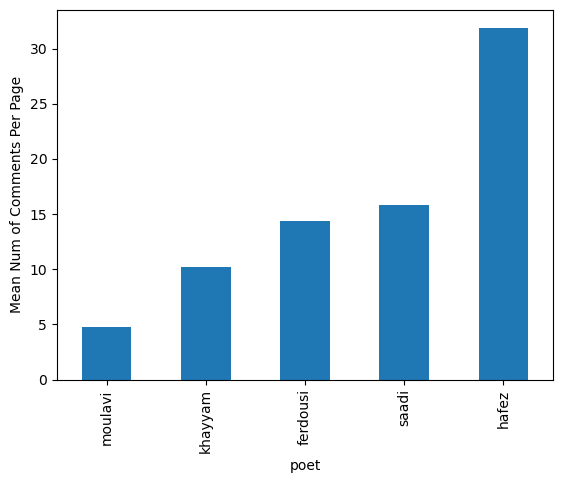

In [291]:
mean_page_comment_poet.plot(kind='bar', ylabel='Mean Num of Comments Per Page', legend=False)

<h2 style='direction:ltr;'>  Frequency Analysis </h2>



### <h3>Tokenization of Texts</h3>

<div>
    The first step in frequency analysis is tokenizing the text. Each of the Ganjoor comments has been split into individual words using the Hazm tokenizer. The input to the tokenizer is the normalized data obtained from the previous preprocessing steps.
</div>



In [453]:
from hazm import word_tokenize
df["tokenized_comment"] = df["comment_as_sentences"].apply(lambda sentences: word_tokenize(''.join(sentences))) 

df[["tokenized_comment"]][5:10]

,tokenized_comment
5,"[توجه, به, تذکر, شادروان, فروغی, راجع, به, این, دیباچه, در, پاورقی, این, بخش, از, تصحیحش, از, کلیات, سعدی, ضروری, است, :, «, این, دیباچه, بی, هیچ, تردید, از, شیخ, سعدی, نیست, و, چون, در, نسخه‌های, قدیم, و, معتبر, که, ما, در, دست, داریم, نیست, ناگزیر, از, روی, نسخ, چاپی, و, نسخه‌هایی, که, در, حدود, قرن, دهم, کتابت, شده, تصحیح, کردیم, », .]"
6,"[بنام, خدا, عبارت, «, جل, جلاله, و, عم, نواله, », به, صورتهای, مختلف, در, برخی, خطب, بزرگان, دین, ،, دیده_شده_است, ., مثلا, سید, رضی, به, هنگام, بیان, برخی, از, خطبه‌های, امیرالمومنین, (, ع, ), از, این, تعبیر, استفاده, کرده_است, ., در, آغاز, خطبه, ۸۶, نهج, البلاغه, چنین, گفته_است, :, من, خطبة, له, (, علیه, السلام, ), و, فیها, بیان, صفات, الحق, جل, جلاله, ،, معنای, خبری, عبارت, سعدی, در, آغاز, دیباچه, خود, چنین, است, :, «, بزرگی, و, جلالت, خداوند, عظیم‌تر, از, تصور, است, و, نعمتهای, او, عام, است, و, همه, را, فرا, می‌گیرد, ., », در, واقع, این, عبارت, ...]"
7,"[درود, ., مصرع‌های, دوم, آخرین, دو, بیتی, این, صفحه, جابجا, نوشته, شده, ؛, یعنی, باید, اینچنین, باشد, :, ای, برتر, از, خیال, و, قیاس, و, گمان, و, وهم, وز, هر, چه, گفته‌اند, و, شنیدیم, و, دیده‌ایم, مجلس, تمام, گشت, و, به, آخر, رسید, عمر, ما, همچنان, در, اول, وصف, تو, مانده‌ایم, سپاس, .]"
8,"[سلام, خسته, نباشید, ., فکر, می‌کنم, در, بیت, آخر, «, به, شیر, », صحیح‌تر, باشد, ., ---, با, تشکر, ،, طبق, پیشنهاد, شما, «, بشیر, », با, «, به, شیر, », جایگزین, شد, .]"
9,"[استاد, محمد, رضا, شجریان, در, کاست, فریاد, این, شعر, را, خوانده_است]"


<h3>
    Removing Stopwords
</h3>
<div>
    Stopwords are common words in a language that usually do not carry meaningful information in textual data analysis. However, the "meaningfulness" of these words depends on the context of the text. Generally, conjunctions and prepositions used in every language are statistically insignificant in many natural language processing applications. For instance, a search engine should not assign the same weight to conjunctions and prepositions as it does to other words that determine the actual intent of a query. In frequency analysis, the frequency of words like "and", "to", and "from" is not of particular interest and should be removed prior to the analysis.
</div>
<br/>
<div>
    To remove stopwords, the Hazm library has been used as shown in the code snippet below. This library includes a default list of Persian stopwords. Considering the context of the analyzed text in this assignment—descriptive comments with a relatively formal tone—these default stopwords seemed appropriate for the intended analysis.
</div>


In [565]:
stop_words = hazm.stopwords_list()
' , '.join(stop_words[:50])

'و , در , به , از , که , این , را , با , است , برای , آن , یک , خود , تا , کرد , بر , هم , نیز , گفت , می\u200cشود , وی , شد , دارد , ما , اما , یا , شده , باید , هر , آنها , بود , او , دیگر , دو , مورد , می\u200cکند , شود , کند , وجود , بین , پیش , شده_است , پس , نظر , اگر , همه , یکی , حال , هستند , من'

In [566]:
from hazm import word_tokenize
df["tokenized_comment_stripped"] = df["tokenized_comment"].apply(lambda words: [w for w in words if w not in stop_words]) 

df[["tokenized_comment", "tokenized_comment_stripped"]].iloc()[:3]


,tokenized_comment,tokenized_comment_stripped
0,"[با, درود, خدمت, اساتید, «, آمیزاده, نگه, دار, که, مصحف, ببرد, », به, چه, معناست, ؟, سپاسگزارم]","[درود, خدمت, اساتید, «, آمیزاده, نگه, مصحف, ببرد, », معناست, ؟, سپاسگزارم]"
1,"[محمد, جان, یعنی, ادمیزاد, را, بنگر, که, قران, میدزدد, -, نگه, دار, مانند, گوش, دار, به, معنی, بنگر, است, و, مضمون, بیت, اینست, که, با, انکه, دیو, از, قران, خواندن, میگریزد, پاره‌ای, از, انسانها, چون, از, دستش, اید, حتی, قران, را, میدزدد]","[محمد, جان, ادمیزاد, بنگر, قران, میدزدد, -, نگه, گوش, معنی, بنگر, مضمون, بیت, اینست, انکه, دیو, قران, خواندن, میگریزد, پاره‌ای, انسانها, دستش, اید, قران, میدزدد]"
2,"[خزما, از, وی, باز, نستانند, -, درست, ایت, و, نه, باز, ستانند, همانگونه, که, میبینیم, در, اخر, هم, تاکید, کرده, که, فرمود, تا, بها, و, خرما, از, بقالان, باز, نستانند, و, زر, پس, دهند]","[خزما, نستانند, -, درست, ایت, ستانند, همانگونه, میبینیم, اخر, تاکید, فرمود, بها, خرما, بقالان, نستانند, زر]"


<div>
The code snippet below uses the HAZM stopword list to remove stopwords from all comments. As shown in the output, the filtered tokens are not ideal—low-value characters still remain in the word list for each comment. Therefore, the next code snippet adds additional symbols to the stopword list to ensure only meaningful words are extracted. In the output, the effect of tokenization after adding the new stopwords is visible. (The right column contains the updated tokens.)
</div>


In [567]:
modified_stop_words = hazm.stopwords_list() + [',', '.', ':', '«', '»', '(', ')', '،', '-', '?', '؟', '-']

df["stripped2"] = df["tokenized_comment_stripped"].apply(lambda words: [w for w in words if w not in modified_stop_words]) 

df[["tokenized_comment_stripped", "stripped2"]].iloc()[:3]

,tokenized_comment_stripped,stripped2
0,"[درود, خدمت, اساتید, «, آمیزاده, نگه, مصحف, ببرد, », معناست, ؟, سپاسگزارم]","[درود, خدمت, اساتید, آمیزاده, نگه, مصحف, ببرد, معناست, سپاسگزارم]"
1,"[محمد, جان, ادمیزاد, بنگر, قران, میدزدد, -, نگه, گوش, معنی, بنگر, مضمون, بیت, اینست, انکه, دیو, قران, خواندن, میگریزد, پاره‌ای, انسانها, دستش, اید, قران, میدزدد]","[محمد, جان, ادمیزاد, بنگر, قران, میدزدد, نگه, گوش, معنی, بنگر, مضمون, بیت, اینست, انکه, دیو, قران, خواندن, میگریزد, پاره‌ای, انسانها, دستش, اید, قران, میدزدد]"
2,"[خزما, نستانند, -, درست, ایت, ستانند, همانگونه, میبینیم, اخر, تاکید, فرمود, بها, خرما, بقالان, نستانند, زر]","[خزما, نستانند, درست, ایت, ستانند, همانگونه, میبینیم, اخر, تاکید, فرمود, بها, خرما, بقالان, نستانند, زر]"


<h3>Word Frequency Analysis</h3>
<div> Following normalization and the removal of low-value stopwords, we proceed with word frequency analysis on the comments associated with each poet's poem pages. This step helps uncover the most commonly used meaningful words within the user-generated content. <br/><br/> In the code snippet provided below, the comments are first grouped by poet, and then tokenized word lists are analyzed using the <code>FreqDist</code> class from the <code>nltk</code> library. This class efficiently computes word frequencies. For each poet, the top 25 most frequently occurring words are extracted, providing insight into recurring themes, vocabulary, or linguistic patterns. <br/><br/> The results are presented in a structured DataFrame that lists the most frequent words for each poet, serving as a useful tool for comparative analysis and thematic exploration. </div>

In [ ]:

from nltk import FreqDist
data_per_poet = df.groupby(by=['poet'])["stripped2"]

tokenized_comments_per_poet = data_per_poet.apply(lambda x: np.array(x, dtype=object))
freq_dist = {}
for poet in data_per_poet:
    wlist_poet = list(np.concatenate(tokenized_comments_per_poet[poet[0]]).flatten())
    freq_dist[poet[0]] = FreqDist(wlist_poet).most_common(25)

freq_dist
fdf = pd.DataFrame(freq_dist)
fdf


,ferdousi,hafez,khayyam,moulavi,saadi
0,"(بیت, 153)","(حافظ, 352)","(خیام, 153)","(…, 79)","(بیت, 194)"
1,"(شاهنامه, 102)","(بیت, 283)","(رباعی, 90)","(مولانا, 79)","(سعدی, 153)"
2,"(فردوسی, 90)","(معنی, 153)","(مصرع, 61)","(عشق, 73)","(/, 91)"
3,"(درست, 66)","(دل, 148)","(زندگی, 53)","(ای, 71)","(معنی, 90)"
4,"(…, 65)","(سر, 135)","(…, 50)","(بیت, 64)","(شعر, 84)"
5,"(!, 62)","(!, 118)","(جهان, 50)","(هست, 63)","(عشق, 67)"
6,"(معنی, 57)","(معشوق, 114)","(دنیا, 46)","(!, 57)","(=, 66)"
7,"(جهان, 54)","(ای, 113)","(بیت, 45)","(جان, 53)","(استاد, 63)"
8,"(ز, 54)","(عشق, 111)","(هست, 41)","(انسان, 48)","(…, 63)"
9,"(زمین, 54)","(انسان, 109)","(شعر, 39)","(معنی, 47)","(شیر, 59)"


### <h3>Comparison of References to Different Poets in the Comment Sections of Each Poet’s Page</h3>

<div>
    In this section, we analyze the text of user comments on each poet’s page to determine how often other poets are mentioned. Specifically, for every pair of poets, we calculate the average number of times one poet is referenced in the comment sections of another’s poems.
    <br/><br/>
    This pairwise reference frequency serves as an indicator of how often poets are compared, discussed, or associated with one another by the Ganjoor user community. The resulting data highlights connections between poets based on how frequently they appear in each other’s discussions.
    <br/><br/>
    Such references may reflect similarities in their poetic themes, literary style, philosophical perspectives, or even historical time periods. Moreover, mutual references between poets may suggest strong cultural or interpretive associations perceived by readers and commentators.
</div>

---

